d:\anaconda3\envs\torchgpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cargando el tokenizador y el modelo base: yiyanghkust/finbert-tone
Modelo y tokenizador cargados exitosamente.
Usando dispositivo: cuda


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Dataset cargado exitosamente.

Distribución de etiquetas después de la limpieza:
sentiment_type
0    8767
2    4775
1    2970
Name: count, dtype: int64

Distribución de etiquetas del dataset sobremuestreado:
sentiment_type
2    8767
0    8767
1    8767
Name: count, dtype: int64

--- Evaluación de rendimiento ---
Accuracy: 0.2781

Informe de Clasificación:
              precision    recall  f1-score   support

    Positivo       0.13      0.02      0.04      8767
    Negativo       0.32      0.75      0.44      8767
      Neutro       0.14      0.06      0.08      8767

    accuracy                           0.28     26301
   macro avg       0.19      0.28      0.19     26301
weighted avg       0.19      0.28      0.19     26301



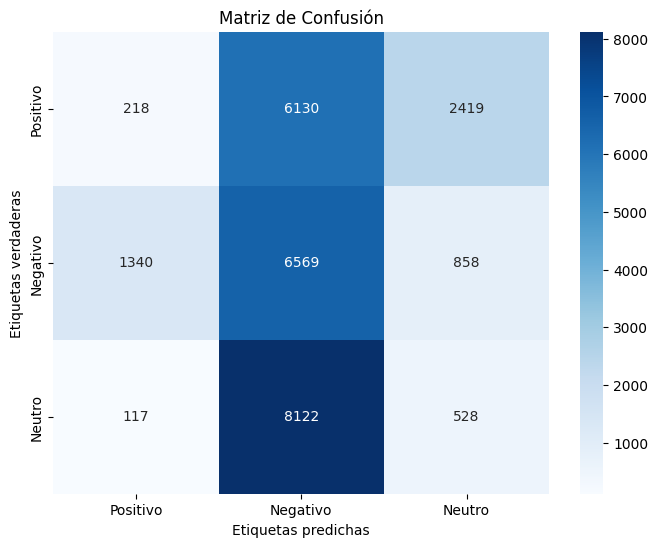

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
##from google.colab import drive
from imblearn.over_sampling import RandomOverSampler

model_path = "C:\\Users\\migue\Downloads\\trial_3_epoch_4_step_Best_model.pt"
base_model = "yiyanghkust/finbert-tone"
num_labels = 3

try:
    print(f"Cargando el tokenizador y el modelo base: {base_model}")
    tokenizer = AutoTokenizer.from_pretrained(base_model)
    model = AutoModelForSequenceClassification.from_pretrained(base_model, num_labels=num_labels)
    model.load_state_dict(torch.load(model_path))
    print("Modelo y tokenizador cargados exitosamente.")
except Exception as e:
    print(f"Error al cargar el modelo o tokenizador: {e}")
    exit()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")
model.to(device)

##drive.mount('/content/drive')
csv_path = 'C:\\Users\\migue\\Documents\\Keep_Coding\\Neurotrader\\data\\raw\\dataset_twitter.csv'

try:
    df = pd.read_csv(csv_path)
    print("Dataset cargado exitosamente.")

    if 'clean_text' not in df.columns or 'sentiment_type' not in df.columns:
        print("Error: El dataset no tiene las columnas 'clean_text' y 'sentiment_type'. Por favor, renómbralas.")
        exit()

    
  
    label_map = {'positive': 0, 'negative': 1, 'neutral': 2}
    df['sentiment_type'] = df['sentiment_type'].astype(str).str.lower().str.strip()
    df['sentiment_type'] = df['sentiment_type'].map(label_map)
    df.dropna(subset=['sentiment_type'], inplace=True)
    print("\nDistribución de etiquetas después de la limpieza:")
    print(df['sentiment_type'].value_counts())

    X = df[['clean_text']]
    Y = df['sentiment_type']

    oversampler = RandomOverSampler(random_state=10)
    X_resampled, y_resampled = oversampler.fit_resample(X, Y)

    df_resampled = pd.DataFrame({'clean_text': X_resampled['clean_text'], 'sentiment_type': y_resampled})
    print("\nDistribución de etiquetas del dataset sobremuestreado:")
    print(df_resampled['sentiment_type'].value_counts())
    
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en la ruta: {csv_path}")
    exit()



batch_size = 32
predictions = []
true_labels = []

model.eval()
with torch.no_grad():
    for i in range(0, len(df_resampled), batch_size):
        x = df_resampled['clean_text'][i:i+batch_size].tolist()
        y = df_resampled['sentiment_type'][i:i+batch_size].tolist()

        encoded_batch = tokenizer(x,
                                   padding=True,
                                   truncation=True,
                                   return_tensors='pt')

        input_ids = encoded_batch['input_ids'].to(device)
        attention_mask = encoded_batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1).cpu().numpy()

        predictions.extend(batch_predictions)
        true_labels.extend(y)

predictions = np.array(predictions)
true_labels = np.array(true_labels)

print("\n--- Evaluación de rendimiento ---")
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.4f}")

print("\nInforme de Clasificación:")
print(classification_report(true_labels, predictions, target_names=['Positivo', 'Negativo', 'Neutro']))

# Muestra la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positivo', 'Negativo', 'Neutro'], yticklabels=['Positivo', 'Negativo', 'Neutro'])
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas verdaderas')
plt.title('Matriz de Confusión')
plt.show()